# Project 4: Scraping Job Postings

Going to use indeed to get job data and find out what factors affect salary.

In [227]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Question 1: Predicting Salary

In [2]:
df65 = pd.read_csv("./indeed65k.csv")

In [45]:
df65.head()

,salary,star_rating,summary,reviews,sponsored,location,job_title,company_name
0,NaN,width:43.2px,"<span class=""summary"">ZapLabs’ <b>Data</b> tea...",50,NaN,"Emeryville, CA",Junior Data Analyst,"<span class=""company"">\n <a data-tn-element..."
1,NaN,NaN,"<span class=""summary"" itemprop=""description"">\...",NaN,NaN,"San Francisco, CA",Risk Data Scientist,"<span class=""company"" itemprop=""hiringOrganiza..."
2,NaN,width:51.0px,"<span class=""summary"" itemprop=""description"">\...",335,NaN,"San Francisco, CA 94107","Data Scientist - San Francisco, CA","<span class=""company"" itemprop=""hiringOrganiza..."
3,NaN,width:44.4px,"<span class=""summary"" itemprop=""description"">\...","2,494",NaN,"San Francisco, CA 94109",Data Scientist 2 | Utilities SaaS Analytics,"<span class=""company"" itemprop=""hiringOrganiza..."
4,NaN,width:54.0px,"<span class=""summary"" itemprop=""description"">\...",2,NaN,"San Francisco, CA 94107",Data Scientist,"<span class=""company"" itemprop=""hiringOrganiza..."


Need to do a little cleaning on this, summary and company name didn't come in right

In [3]:
# parsing out the text from summary html

summaries = [BeautifulSoup(summary, 'html.parser').get_text() for summary in df65['summary']]

In [4]:
# filling nas on company name so we can do the same.

df65['company_name'].fillna("no company name", inplace=True)

In [5]:
# parsing out company names from html

company_names = [BeautifulSoup(name, 'html.parser').get_text() if name != "no company name" else name for name in df65['company_name']]

In [53]:
company_names[0:10]

[u'\n\n        Realogy Corporate',
 u'\n\n    LendingHome\n',
 u'\n\n\n        PG&E\n',
 u'\n\n\n        Oracle\n',
 u'\n\n\n        Smule\n',
 u'\n\n    Winton Capital\n',
 u'\n\n    Grammarly\n',
 u'\n\n\n        Uber\n',
 u'\n\n    Rakuten, Inc.\n',
 u'\n\n\n        Fanatics Inc.\n']

In [6]:
# getting rid of extra characters on company name and summary

company_names = [name.replace("\n", "").replace("  ", "") for name in company_names]
summaries = [summary.replace("\n", "") for summary in summaries]

In [7]:
# updating dataframe with cleaned data for companies and summary.

df65['company_name'] = company_names
df65['summary'] = summaries

In [8]:
del(df65['sponsored'])

In [ ]:
# We can get an actual number out of the star ratings block by getting rid of the 'width' and 'px' strings
# and then scaling it a bit.

In [9]:
star_ratings = [rating[6:10] if not pd.isnull(rating) else rating for rating in df65['star_rating']]

In [10]:
df65['star_rating'] = star_ratings

In [11]:
df65['star_rating'] = (pd.to_numeric(df65['star_rating']) - 10) / 10.

In [12]:
# I'm also just going to get rid of the zipcode from location.

locations = []

for location in df65.location:
    location = location.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("9", "")
    locations.append(location)

In [13]:
df65.location = locations

### Imputing missing data

I'd like to impute missing values for star rating and reviews.  For star rating, I'll look at the distribution, and probably impute with the mean or median.  for reviews I'll just imput nan's with 0, they just don't have any reviews.

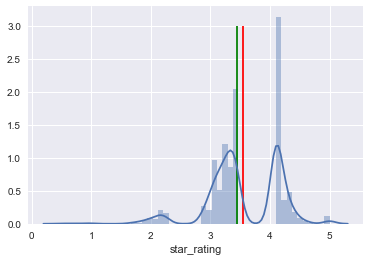

In [89]:
sns.distplot(df65.loc[df65['star_rating'].notnull(), 'star_rating'])
plt.vlines(df65.loc[df65['star_rating'].notnull(), 'star_rating'].mean(), 0,3, color='red')
plt.vlines(df65.loc[df65['star_rating'].notnull(), 'star_rating'].median(), 0,3, color='green')


# There's kind of an odd jump from 3.5 to 4.
# I think I'll impute the missing values with the median, both because it reps the skew of the data a little better
# and because it's closer to where there actually seem to be values.

In [14]:
df65.star_rating.fillna(df65.loc[df65['star_rating'].notnull(), 'star_rating'].median(), inplace=True)

In [15]:
df65.reviews.fillna(0, inplace=True)

In [98]:
df65.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17907 entries, 0 to 17906
Data columns (total 7 columns):
salary          1789 non-null object
star_rating     17907 non-null float64
summary         17907 non-null object
reviews         17907 non-null object
location        17907 non-null object
job_title       17907 non-null object
company_name    17907 non-null object
dtypes: float64(1), object(6)
memory usage: 979.4+ KB


In [96]:
df65.head(10)

,salary,star_rating,summary,reviews,location,job_title,company_name
0,NaN,3.32,ZapLabsâ Data team is looking for data geeks...,50,"Emeryville, CA",Junior Data Analyst,Realogy Corporate
1,NaN,3.44,LendingHome is seeking a talented and highly a...,0,"San Francisco, CA",Risk Data Scientist,LendingHome
2,NaN,4.10,The Data Scientist will work ontechnical devel...,335,"San Francisco, CA","Data Scientist - San Francisco, CA",PG&E
3,NaN,3.44,Team of Data Scientists and Data Analysts to p...,"2,494","San Francisco, CA",Data Scientist 2 | Utilities SaaS Analytics,Oracle
4,NaN,4.40,"Familiarity with ""big data"" tools:. Ability to...",2,"San Francisco, CA",Data Scientist,Smule
5,NaN,3.44,Data Visualization Developer. As the companyâ...,0,"San Francisco, CA",Data Visualization Developer (Data),Winton Capital
6,NaN,3.44,"To help us reach that goal, Grammarly is looki...",0,"San Francisco, CA",Data Scientist,Grammarly
7,NaN,3.44,Identify and own data latency and data quality...,169,"San Francisco, CA",Data Scientist and Data Analyst - Communicatio...,Uber
8,NaN,3.44,"Apply machine learning, deep learning algorith...",0,"San Mateo, CA",Data Scientist,"Rakuten, Inc."
9,NaN,3.26,Data Science Engineer. Experience with big dat...,216,"San Mateo, CA",Data Scientist,Fanatics Inc.


In [ ]:
# now let's load in the rest of the data sets, and do the same cleaning on those.

In [16]:
df90 = pd.read_csv("./indeed90k.csv")
df105 = pd.read_csv("./indeed105k.csv")
df130 = pd.read_csv("./indeed130k.csv")

In [17]:
dfs = [df90, df105, df130]

for df in dfs:
    
    # parsing out the text from summary html

    summaries = [BeautifulSoup(summary, 'html.parser').get_text() for summary in df['summary']]

    # filling nas on company name so we can do the same.

    df['company_name'].fillna("no company name", inplace=True)
    company_names = [BeautifulSoup(name, 'html.parser').get_text() if name != "no company name" else name for name in df['company_name']]

    # getting rid of extra characters on company name and summary

    company_names = [name.replace("\n", "").replace("  ", "") for name in company_names]
    summaries = [summary.replace("\n", "") for summary in summaries]

    # updating to cleaned data.

    df['company_name'] = company_names
    df['summary'] = summaries

    del(df['sponsored'])

    star_ratings = [rating[6:10] if not pd.isnull(rating) else rating for rating in df['star_rating']]

    df['star_rating'] = star_ratings
    df['star_rating'] = (pd.to_numeric(df['star_rating']) - 10) / 10.

    # I'm also just going to get rid of the zipcode from location.

    locations = []

    for location in df.location:
        location = location.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("9", "")
        locations.append(location)

    df.location = locations

    df.star_rating.fillna(df.loc[df['star_rating'].notnull(), 'star_rating'].median(), inplace=True)

    df.reviews.fillna(0, inplace=True)

In [105]:
df90.head()

,salary,star_rating,summary,reviews,location,job_title,company_name
0,NaN,4.28,"As a Data Scientist , you will work in a team ...",790,"Palo Alto, CA",Data Scientist,SAP
1,NaN,4.10,LendingHome is seeking a talented and highly a...,0,"San Francisco, CA",Risk Data Scientist,LendingHome
2,NaN,4.10,The Data Scientist will work ontechnical devel...,335,"San Francisco, CA","Data Scientist - San Francisco, CA",PG&E
3,NaN,3.44,Team of Data Scientists and Data Analysts to p...,"2,493","San Francisco, CA",Data Scientist 2 | Utilities SaaS Analytics,Oracle
4,NaN,4.10,Data Visualization Developer. As the companyâ...,0,"San Francisco, CA",Data Visualization Developer (Data),Winton Capital


In [107]:
df105.head()

,salary,star_rating,summary,reviews,location,job_title,company_name
0,NaN,4.28,"As a Data Scientist , you will work in a team ...",790,"Palo Alto, CA",Data Scientist,SAP
1,NaN,3.44,Identify and own data latency and data quality...,169,"San Francisco, CA",Data Scientist and Data Analyst - Communicatio...,Uber
2,NaN,4.10,Data Scientist- Digital. Writing software to c...,"3,852","San Francisco, CA",Data Scientist- Digital,Capital One
3,NaN,4.22,You are good at build collaborative relationsh...,172,"San Francisco, CA",Data Scientist,Autodesk
4,NaN,4.16,Common data structures and algorithms. Youâr...,37,"San Francisco, CA",Machine Learning Infrastructure Engineer,Twitter


In [108]:
df105.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20268 entries, 0 to 20267
Data columns (total 7 columns):
salary          896 non-null object
star_rating     20268 non-null float64
summary         20268 non-null object
reviews         20268 non-null object
location        20268 non-null object
job_title       20268 non-null object
company_name    20268 non-null object
dtypes: float64(1), object(6)
memory usage: 1.1+ MB


In [109]:
df130.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 7 columns):
salary          48 non-null object
star_rating     413 non-null float64
summary         413 non-null object
reviews         413 non-null object
location        413 non-null object
job_title       413 non-null object
company_name    413 non-null object
dtypes: float64(1), object(6)
memory usage: 22.7+ KB


In [114]:
df65.shape

(9600, 7)

In [18]:
# Going to drop duplicates from everything

df65 = df65.drop_duplicates()
df90 = df90.drop_duplicates()
df105 = df105.drop_duplicates()
df130 = df130.drop_duplicates()

In [19]:
# Looks like this is all good!  Now I need to add the salary group labels and then do outer joins to get rid of overlap.

common_65 = df65.merge(df90,on=['summary', 'job_title']).drop_duplicates()
print len(common_65)

1334


In [123]:
len(df65)

11624

In [124]:
len(df65[~df65.summary.isin(common_65.summary)])

10012

In [125]:
# There's some stuff getting deleted from the 65 k that's extra, but it must be duplicate summaries, which 
# I'm fine losing

11624 - 1334

10290

In [20]:
# Making a new data frame that's just the lower salary group.

df_65_90 = df65[~df65.summary.isin(common_65.summary)]

In [21]:
common_90 = df90.merge(df105,on=['summary', 'job_title']).drop_duplicates()
df_90_105 = df90[~df90.summary.isin(common_90.summary)]

common_105 = df105.merge(df130,on=['summary', 'job_title']).drop_duplicates()
df_105_130 = df105[~df105.summary.isin(common_90.summary)]

In [22]:
# Ok, now each dataframe just includes jobs from it's particular salary range.  Now let's add the salary labels.

df_65_90["salary_range"] = "65000 to 90000"
df_90_105["salary_range"] = "90000 to 105000"
df_105_130["salary_range"] = "105000 to 130000"
df130["salary_range"] = "Over 130000"

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [130]:
df130.head()

,salary,star_rating,summary,reviews,location,job_title,company_name,salary_range
0,NaN,4.22,Working closely with Subject Matter Experts (S...,673,"Mountain View, CA",Data Scientist,Intuit,Over 130000
1,NaN,4.40,Senior Data Scientists solve problems through ...,10,"San Francisco, CA",Senior Data Scientist - Web Clients,Twitch,Over 130000
2,NaN,4.16,Collaborate closely with qualitative researche...,37,"San Francisco, CA",Quantitative User Researcher,Twitter,Over 130000
3,NaN,4.16,Twitter data scientists create increasingly so...,37,"San Francisco, CA","Senior Data Scientist, Product",Twitter,Over 130000
4,NaN,4.16,Work with data engineers on data quality asses...,"2,053","San Francisco, CA",Sr Data Scientist,General Electric,Over 130000


In [23]:
# Now let's put them all in the same dataframe

frames = [df_65_90, df_90_105, df_105_130, df130]

df = pd.concat(frames, axis=0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20454 entries, 0 to 411
Data columns (total 8 columns):
salary          1494 non-null object
star_rating     20454 non-null float64
summary         20454 non-null object
reviews         20454 non-null object
location        20454 non-null object
job_title       20454 non-null object
company_name    20454 non-null object
salary_range    20454 non-null object
dtypes: float64(1), object(7)
memory usage: 1.4+ MB


# Let's do a little EDA 

In [157]:
len(df.company_name.value_counts()) # There's a ton of different companies... may be tough to use this.

10048

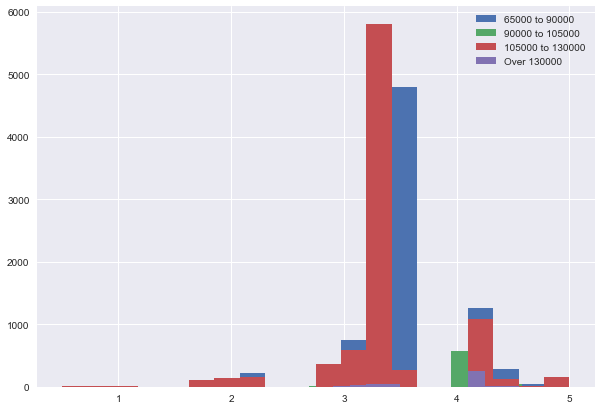

In [145]:
# How does star rating look over the different categories?

fig, ax = plt.subplots(1, 1, figsize=(10,7))

for salary in list(df['salary_range'].unique()):
    ax.hist(df.loc[df['salary_range'] == salary, 'star_rating'], stacked=True, label=salary, bins=20)
    ax.legend(loc="upper right")
    
# it's a bit hard to tell from this, but it does look like the 130k jobs skew a bit higher
# also looks like 90 to 105 group might not have a lot of data.

In [153]:
df['reviews'] = [int(str(review).replace(",", "")) for review in df['reviews']]

In [155]:
df.salary_range.value_counts()

65000 to 90000      10012
105000 to 130000     8809
90000 to 105000      1250
Over 130000           383
Name: salary_range, dtype: int64

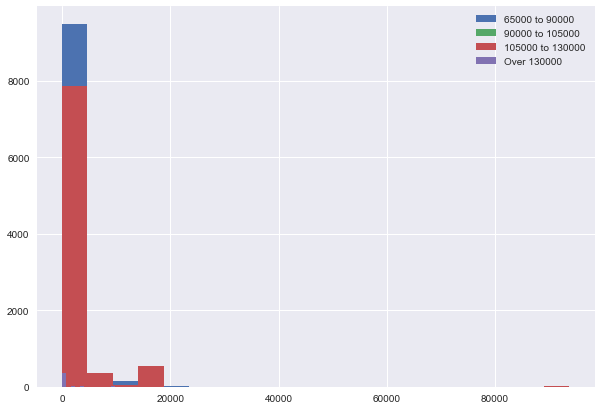

In [154]:
# What about reviews?

fig, ax = plt.subplots(1, 1, figsize=(10,7))

for salary in list(df['salary_range'].unique()):
    ax.hist(df.loc[df['salary_range'] == salary, 'reviews'], stacked=True, label=salary, bins=20)
    ax.legend(loc="upper right")
    
# Not super helpful either.

In [2]:
import sqlite3

conn = sqlite3.Connection("./project4.sqlite")

In [3]:
conn.text_factory = str

In [29]:
df.to_sql("project_4_data", con=conn, if_exists='replace')

# Introducing some NLP elements.

I'm going to go ahead and count vectorize the summary column./

In [232]:
df = pd.read_sql("SELECT * from project_4_data", con=conn)

In [229]:
del(df['index'])

In [230]:
from sklearn.feature_extraction.text import CountVectorizer

In [233]:
cvt      =  CountVectorizer(strip_accents='unicode', ngram_range=(1,4), stop_words="english", min_df=.001, max_df = .75)
X_all    =  cvt.fit_transform(df['summary'])
columns  =  cvt.get_feature_names()

x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(10)

,freq
sales,3174
position,2345
time,2169
experience,2071
work,2052
looking,1814
team,1700
service,1685
company,1646
data,1634


In [41]:
# There seems to be a lot of "kwik trip" references in here.  My search clearly went beyond data jobs it would appear.
# That should be fine, but we may have to go back and refine the data mining process.

# What's good to see fromthis is it's not readily apparent that we need stop words other than just "english"

In [42]:
tf_df.sort_values("freq", ascending=False)

,freq
sales,3174
position,2345
time,2169
experience,2071
work,2052
looking,1814
team,1700
service,1685
company,1646
data,1634


In [43]:
# This may be getting a bit more useful.

len(tf_df)

3455

In [ ]:
# it's hard for me to imagine that we're going to get much signal out of using single words, our dataset will
# just be so much wider than it is long.  I'd like to go ahead and do some modeling with this

In [49]:
x_df.shape

(20454, 3455)

In [50]:
df.shape

(20454, 8)

In [234]:
df_words = df.join(x_df, lsuffix = '_VALUE', rsuffix='_WORD')

In [60]:
# seems like that did the trick.

df_words.shape

(20454, 3463)

In [68]:
for c in df_words.columns:
    if 'salary' in c:
        print c

salaryvalue
salary_range
base salary
competitive salary
job type time salary
salaryword
salary benefits
salary dependent
salary plus
time salary
type time salary


# One Hot Encoding 

For the categorical data we grabbed from Indeed, we need to do some one hot encoding so we can put it into our model

In [ ]:
# I'm just going to group companies that don't have that many values together.

In [78]:
# Taking the first 400 seems to get about 70%, let's do that.

sum(df['company_name'].value_counts()[0:400])

6898

In [235]:
below_5_comp = list(df['company_name'].value_counts()[400:].index)

In [21]:
below_5_comp[0:10]

['A&A Transfer, Inc.',
 'Hallmark',
 'Lord & Taylor',
 'Clean Harbors',
 'NonstopDelivery, Inc.',
 'Check Point Software Technologies Ltd.',
 'ESF Careers (Engineering Search Firm Inc.)',
 'Intarcia Therapeutics',
 'Brooks Sports, Inc.',
 'Dallas County, TX']

In [236]:
df_words['company_name'] = [company if company not in below_5_comp else "other_company" for company in df_words['company_name']]


In [23]:
companies_ohe = pd.get_dummies(df_words['company_name'], prefix="company_name")

In [88]:
companies_ohe.head()

,company_name_24 Hour Fitness,"company_name_300-Concentra Health Services, Inc. (Concentra)",company_name_3M,company_name_7-Eleven,company_name_A-Plus Care HHC Inc,"company_name_A2Z Development Center, Inc.",company_name_ABCM Corporation,"company_name_ATR International, Inc.",company_name_AbbVie,company_name_Accenture,...,company_name_WorkSource Inc.,company_name_Workbridge Associates,company_name_Workplace Alaska,company_name_XPO Logistics,company_name_ZARA,"company_name_Zoes Kitchen | Zoes Kitchen, Inc.",company_name_adidas,company_name_eBay Inc.,company_name_eXcell,company_name_other_company
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
df_words = df_words.join(companies_ohe)

In [238]:
del(df_words['company_name'])

In [239]:
df_words.shape

(20454, 3864)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20454 entries, 0 to 411
Data columns (total 8 columns):
salary          1494 non-null object
star_rating     20454 non-null float64
summary         20454 non-null object
reviews         20454 non-null object
location        20454 non-null object
job_title       20454 non-null object
company_name    20454 non-null object
salary_range    20454 non-null object
dtypes: float64(1), object(7)
memory usage: 1.4+ MB


In [ ]:
# let's do the same ohe to job title and location

In [95]:
sum(df.job_title.value_counts()[0:1000])

7188

In [99]:
len(df.location.value_counts())

4346

In [104]:
sum(df.location.value_counts()[0:300])

12213

In [240]:
# getting a list of the job titles that are below the threshold
low_jobs = list(df['job_title'].value_counts()[1000:].index)

# updating the titles of those titles to other job
df_words['job_title'] = [job if job not in low_jobs else "other_job" for job in df_words['job_title']]

job_ohe = pd.get_dummies(df_words['job_title'], prefix="job_title")

# getting a list of the locations that are below the threshold
low_loc = list(df['location'].value_counts()[300:].index)

# updating the titles of those titles to other job
df_words['location_VALUE'] = [location if location not in low_loc else "other_location" for location in df_words['location_VALUE']]

loc_ohe = pd.get_dummies(df_words['location_VALUE'], prefix="location")

In [241]:
df_words = df_words.join(job_ohe)
df_words = df_words.join(loc_ohe)

In [242]:
del(df_words['location_VALUE'])
del(df_words['job_title'])

In [ ]:
# Cleaning up reviews

In [243]:
# Getting rid of commas

df_words['reviews_VALUE'] = [str(review).replace(",", "") for review in df_words['reviews_VALUE']]

In [244]:
# Changing reviews from an object to an int.

df_words['reviews_VALUE'] = pd.to_numeric(df_words['reviews_VALUE'])

In [245]:
del(df_words['summary_VALUE'])

In [247]:
# Want to check to make sure all the columns in here are correct now.

# looks like the only things we need to do are get rid of the salary_VALUE column.

for c in df_words.columns[0:10]:
    if df_words[c].dtypes != 'int64':
        print c, "DATA TYPE:", df_words[c].dtypes
        print "________"

star_rating DATA TYPE: float64
________
salary_range DATA TYPE: object
________


In [246]:
del(df_words['salary_VALUE'])

# Modeling

Let's try doing some modeling!


In [248]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB


In [249]:
X = df_words.copy()

del(X['salary_range'])

y = df_words['salary_range']

In [254]:
# let's just see what our baseline is before we get going on the modeling

baseline = 10012. / len(df_words)

baseline

0.48948860858511783

In [251]:
# let's try fitting this with a multinomial naive bayes model first.

mnb = MultinomialNB()

params = {
    'alpha': [0.1,0.5, 1, 2]
}

gscv_mnb = GridSearchCV(mnb, params, cv=5, verbose=1)

In [252]:
gscv_mnb.fit(np.array(X), y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.5, 1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=1)

In [253]:
# That's just a terrible considering it's worse than our baseline.

gscv_mnb.best_score_

0.44485186271633909

In [255]:
gscv_mnb.best_params_

{'alpha': 0.1}

In [34]:
# Going to try random forest, I suspect this will perform better.

rfc = RandomForestClassifier()

param_grid = {
    "max_depth": [10,15,20,25,30],
    "max_features": [100,150,200,300,400],
}

gscv_rfc = GridSearchCV(rfc, param_grid, cv=5, verbose=1)


In [53]:
gscv_rfc.fit(np.array(X), y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 31.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [100, 150, 200, 300, 400], 'max_depth': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [55]:
# Pretty solid best score, I think our baseline is like 50%!

gscv_rfc.best_score_

0.80404810794954529

In [56]:
df_words['salary_range'].value_counts()

65000 to 90000      10012
105000 to 130000     8809
90000 to 105000      1250
Over 130000           383
Name: salary_range, dtype: int64

In [57]:
baseline = 10012. / len(df_words)

In [58]:
baseline

0.48948860858511783

In [ ]:
# oh yeah, huge improvement over the baseline!

In [61]:
gscv_rfc.best_params_

{'max_depth': 30, 'max_features': 400}

In [64]:
rfc = RandomForestClassifier(max_depth=30, max_features=400)

rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=400, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [67]:
# Let's look at what are the factors that are most important in determining salary.

feature_import = pd.DataFrame({
    'feature': X.columns,
    'importance': rfc.feature_importances_
})

In [70]:
feature_import.sort_values('importance', ascending=False, inplace=True)
feature_import.head(20)

,feature,importance
0,star_rating,0.260825
1,reviews_VALUE,0.096418
3857,company_name_other_company,0.088929
5159,location_other_location,0.027319
1975,network,0.021394
776,data,0.019247
1696,license,0.009758
5108,"location_San Francisco, CA",0.007885
2975,store,0.006906
3780,"company_name_T3 recruiters,Inc",0.006674


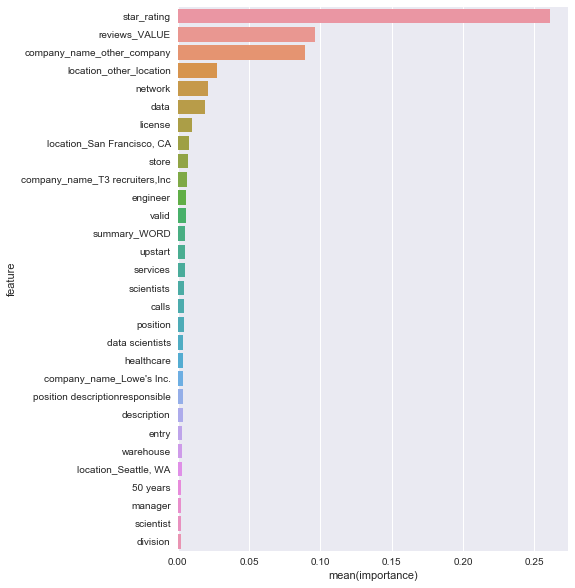

In [75]:
fig = plt.figure(figsize=(7,10))
sns.barplot(y = feature_import.head(30)['feature'], x = feature_import.head(30)['importance'], orient='h')

# Interpreting Results

With Random Forest, it's a bit difficult to say how the categories are associated with different salary levels, but we can interpret the features' individual affect on our overall ability to predict different salary categories.

Star rating has by far the biggest impact on predicting salary.  It makes sense that this would be the case, likely jobs with higher ratings pay better, which is something we observed during EDA as well.  Next most is count of reviews.  I'd imagine that the trend here is that the more reviews a company has, the lower the salary, because bigger companies can get away with paying less, but we'd have to look deeper to know that for sure.

It's interesting that the next to features are "other company" and "other location," which means the smaller locations have an impact on salary.  It does make sense that there may be a difference in salary for these.  Generally bigger cities have higher paying jobs, so the other location category probable corresponds more to smaller salaries.  Also makes sense there would be a pay difference between big and small companies.

"Data" is a word that comes up on here, likely associated with predicting high paying jobs.  Also interesting that "data scientists", "engineer", "license," "manager," and "scientist" all pop up on here, likely connected with higher paying jobs.  Words like "entry," "warehouse," "services," and "store" all come up, likely connected with lower paying jobs.

# Exploring Results

We can do some plotting and exploration to see what categories these high importance features are likely associated with.

### Star Rating and Salary

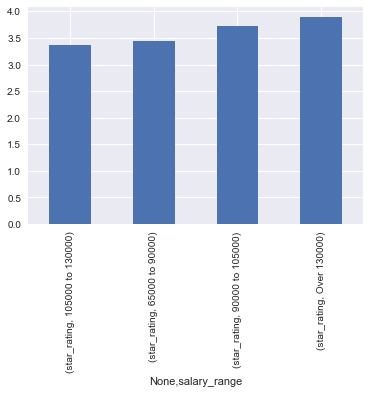

In [82]:
# Looks like just like I suspected, higher star ratings from reviews correspond to jobs with higher salaries.

# weirdly, the 3rd tier salary rank actually has the lowest avg star rating.

df[['salary_range', 'star_rating']].groupby('salary_range').mean().unstack().plot(kind="bar")


### Review count and Salary

In [87]:
df['reviews'] = [review.replace(",", "") for review in df.reviews]
df['reviews'] = pd.to_numeric(df['reviews'])


AttributeError: 'numpy.int64' object has no attribute 'replace'

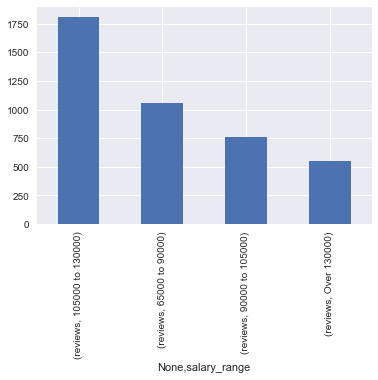

In [88]:
# Looking at reviews and salary range.  Also just like I suspected, looks like higher paying jobs have fewer reviews
# of the company.  May be associated with smaller companies paying more.

df[['salary_range', 'reviews']].groupby('salary_range').mean().unstack().plot(kind="bar")

### Company Name and Salary

Want to look at big vs. small companies pay difference.  Assuming companies that are not in the below_5_comp list are big companies, and ones that are (which we were calling "other companies") are small.

In [90]:
df['company_size'] = ['big' if name not in below_5_comp else "small" for name in df.company_name]

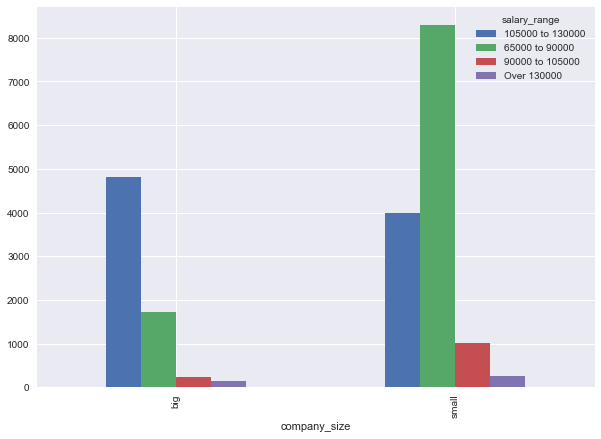

In [101]:
df[['salary_range', 'company_size']].groupby(['company_size', 'salary_range']).size().unstack().plot(kind="bar", 
                                                                                                    figsize=(10,7))

# It looks like small companies actually have alot more LOW paying jobs.  The big companies mostly have the 3rd tier
# 105-130, where as the small mostly have the lowest tier 65k - 90k

# Location and Salary

Let's look at the same thing as company size, except for with city size.

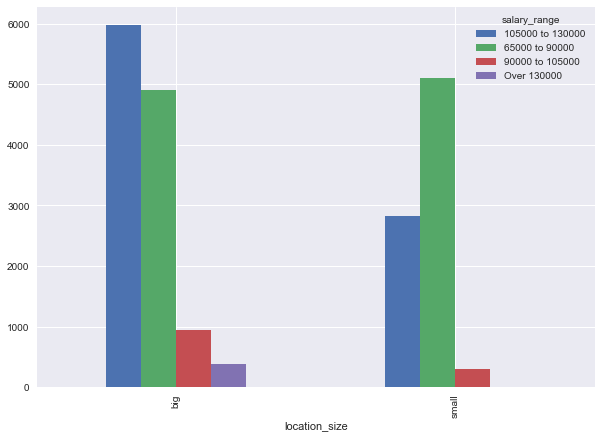

In [102]:


# We'll be assuming that cities that have more job listings are the bigger cities.

df['location_size'] = ['big' if city not in low_loc else "small" for city in df.location]

df[['salary_range', 'location_size']].groupby(['location_size', 'salary_range']).size().unstack().plot(kind="bar", 
                                                                                                    figsize=(10,7))

# As I suspected, looks like big cities pay better, they have way more of the 105-130 jobs, while the 65-90 jobs are
# about even between the two groups.  Big companies are also the only ones that have any jobs that pay over 130k.

## Looking at a few keywords relationships with salary.

### Summary Word: "Data"

This is likely associated with higher paying jobs, let's explore.

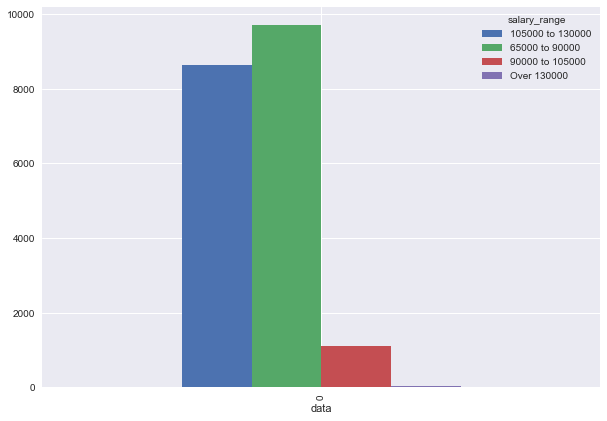

In [107]:
# No mentions of data

df_words.loc[df_words['data'] == 0, ['data', 'salary_range']].groupby(['data', 'salary_range']).size().unstack().plot(kind="bar", 
                                                                                                    figsize=(10,7))

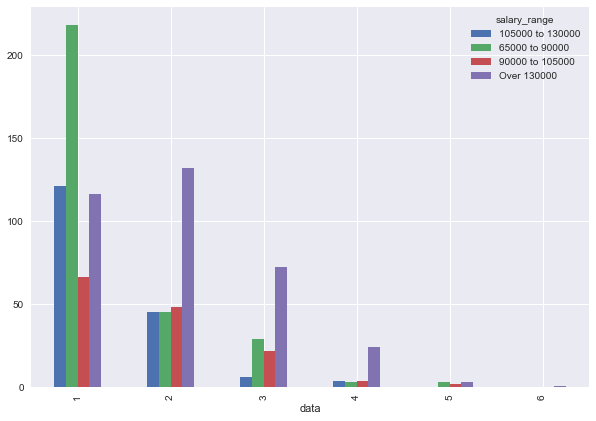

In [109]:
# 1 or more mentions of data

df_words.loc[df_words['data'] != 0, ['data', 'salary_range']].groupby(['data', 'salary_range']).size().unstack().plot(kind="bar", 
                                                                                                    figsize=(10,7))

Pretty clear that 'data' in the summary is associated with higher paying jobs, and the more mentions of data, the higher paying the job is likley to be.  Once we get into 2 or more mentions of data, the count of 130k+ jobs is higher than any other category.  With 0 mentions of data, the lowest tier dominates and there are almost no jobs in the highest paying category.

### Summary Word: "Store"

This is likely associated with lower paying jobs, let's explore


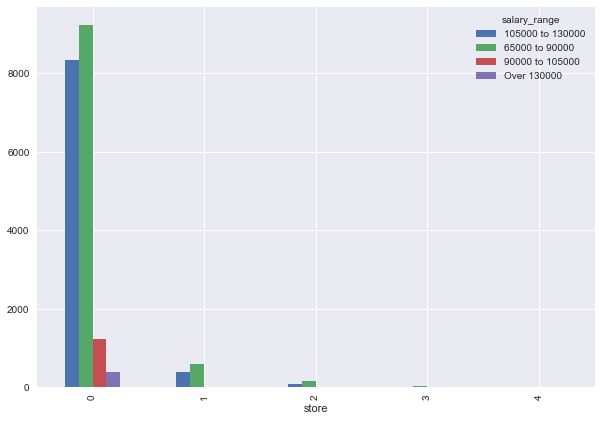

In [110]:
df_words[['store', 'salary_range']].groupby(['store', 'salary_range']).size().unstack().plot(kind="bar", 
                                                                                                    figsize=(10,7))

Most jobs have no mentions of this word, but we can see that as we get into 1, 2 and 3 mentions of this word, we have mostly jobs that pay 65k-90k, and no jobs that pay over 130k.  Looks like this word is associated with lower paying jobs.

### Further Investigation:

There's a bit more we could do to get this even better, including:

1.  Trying more models.  Random Forest performed really well, but it could be interesting to try SVM, Logistic Regression, and Naive Bayes.
2.  Investigating relatioship of more of the important features.  I demonstrated here how you could look into the exact nature of the relationship between important features from the random forest model, but we could keep going deeper with this to see the relationship of other words.

### Overall Takeaways.

1.  Star rating is by far the most impactful variable on predicint job pay.  The higher the company's rating on Indeed, the better the jobs pay.  This is followed by the number of reviews the company has received, with more reviews equating to better pay.
2.  Location has a lot to do with how much a job will pay, with bigger cities having better paying jobs.  Similarly, big companies jobs also pay better.
3.  There are many key words associated with high paying jobs, such as 'data', 'engineer,' and 'scientist.'  These have to do with high skilled jobs.  Low paying jobs are associated with many words that come up in retail and customer service, like 'store,' 'service,' and 'calls.'

# Question 2: Job Title Differentiating Features

### A. Differentiating Data Science Roles from Other Data Roles

In [114]:
# First let's make groups of data related jobs, ds and non-ds

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20454 entries, 0 to 20453
Data columns (total 10 columns):
salary           1494 non-null object
star_rating      20454 non-null float64
summary          20454 non-null object
reviews          20454 non-null int64
location         20454 non-null object
job_title        20454 non-null object
company_name     20454 non-null object
salary_range     20454 non-null object
company_size     20454 non-null object
location_size    20454 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 1.6+ MB


In [256]:
# Going to set up what type of data job each role is based on key words that show up in the job title.

ds_category = []

for i, title in enumerate(df.job_title):
    title = title.lower()
    
    # checking to see if data science related words are in title for ds roles.
    if ("data" in title) and ('science' in title or 'scientist' in title):
        ds_category.append("data_scientist")
        
    # checking to see if data is in title or description for other data related roles.
    elif ("data" in title) or ('data' in df['summary'][i]):
        ds_category.append("data_role")
   
    # all other roles are just non data roles.
    else:
        ds_category.append("non_data_role")
        

In [257]:
# adding this to our initial dataframe

df['ds_category'] = ds_category

In [120]:
df.ds_category.value_counts()

non_data_role     19356
data_role           890
data_scientist      208
Name: ds_category, dtype: int64

In [121]:
X.shape

(20454, 5160)

In [258]:
# Let's also add it to X, so we can split it up and do some modeling.

X['ds_category'] = ds_category

In [259]:
# Just want to limit this to ds roles and data roles.

X_ds = X[X['ds_category'] != "non_data_role"]

In [125]:
# This isn't great that our dataframe is so much wider than it is long now.

X_ds.shape

(1098, 5161)

In [260]:
y_ds = X_ds['ds_category']
del(X_ds['ds_category'])

In [167]:
# Getting rid of all the ohe job_title columns

for c in X_ds.columns:
    if "job_title" in c:
        del(X_ds[c])

In [168]:
X_ds.shape

(1098, 4159)

### A little EDA

Let's just see what words come up most in these two categories.

In [170]:
# what words show up most for data science jobs?

tf_df_ds    =  pd.DataFrame(X_ds[y_ds == "data_scientist"].sum(), columns=["freq"])
tf_df_ds.sort_values("freq", ascending=False)[2:30]

# Pretty unsurprising stuff here.  lots of things you'd expect like machine learning and things.

,freq
data,429.0
company_name_other_company,129.0
scientist,110.0
data scientist,104.0
"location_San Francisco, CA",95.0
scientists,59.0
science,54.0
data science,52.0
data scientists,51.0
team,47.0


In [171]:
# what words show up most for other data jobs?

tf_df_non_ds    =  pd.DataFrame(X_ds[y_ds == "data_role"].sum(), columns=["freq"])
tf_df_non_ds.sort_values("freq", ascending=False)[2:30]

# A lot of mention of 'data entry' here, which you don't see in the data science roles. also some system stuff, maybe
# something like data engineers.

,freq
data,1105.0
company_name_other_company,655.0
location_other_location,232.0
entry,215.0
data entry,198.0
scientists,163.0
"location_San Francisco, CA",153.0
experience,132.0
data scientists,129.0
work,119.0


## Modeling

In [268]:
# We need to get rid of job title columns from our data, that's not what we're interested in here.

for c in X_ds.columns:
    if "job_title" in c:
        del(X_ds[c])

In [261]:
# First let's look at our baseline

y_ds.value_counts()

# Calculating our baseline so we can see how good this model is.

baseline_ds = 890./(890+208)
baseline_ds

0.8105646630236795

In [269]:
# Let's try Logistic Regression to start out, because naive bayes performed so poorly last time.

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

params = {
    "C": [0.2, 0.4, 0.6, 0.8, 1],
    
    # I imagine lasso will be more useful for this problem because of how many features we have, but I'll try both
    "penalty": ['l1', 'l2']
}

gscv_log_reg = GridSearchCV(log_reg, params, cv=3, verbose=1)

In [270]:
gscv_log_reg.fit(np.array(X_ds), y_ds)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.2, 0.4, 0.6, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [271]:
# pretty solid, 6% better than baseline, maybe we can tune this though?

gscv_log_reg.best_score_

0.87887067395264118

In [273]:
# Like i suspected, L1 is the better regularization.  Let's try different values of C

gscv_log_reg.best_params_

{'C': 0.2, 'penalty': 'l1'}

In [274]:
params = {
    "C": [0.02, 0.05, 0.75, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25],
    
    # I imagine lasso will be more useful for this problem because of how many features we have, but I'll try both
    "penalty": ['l1']
}

gscv_log_reg = GridSearchCV(log_reg, params, cv=3, verbose=1)

In [275]:
gscv_log_reg.fit(np.array(X_ds), y_ds)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [0.02, 0.05, 0.75, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [276]:
# we got slightly better, but not much.  Let's try Random Forest.

gscv_log_reg.best_score_

0.88615664845173037

In [172]:
# going to go ahead and do some grid on random forest.

rfc_ds = RandomForestClassifier()

param_grid_ds = {
    "max_depth": [20,25,30,40],
    "max_features": [200,300,400],
}

gscv_rfc_ds = GridSearchCV(rfc, param_grid_ds, cv=3, verbose=1)


In [173]:
gscv_rfc_ds.fit(np.array(X_ds), y_ds)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   15.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [200, 300, 400], 'max_depth': [20, 25, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [174]:
# seems like we picked pretty good parameters

gscv_rfc_ds.best_params_

{'max_depth': 20, 'max_features': 200}

In [177]:
# got out score up a sliver from logistic regression.

# we could maybe improve this by tuning the parameters a little more.

gscv_rfc_ds.best_score_

0.88797814207650272

In [178]:
param_grid_ds = {
    "max_depth": [10,15,20],
    "max_features": [100,150,200],
    "n_estimators": [5,10,20,40]
}

gscv_rfc_ds = GridSearchCV(rfc, param_grid_ds, cv=3, verbose=1)

gscv_rfc_ds.fit(np.array(X_ds), y_ds)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   49.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [100, 150, 200], 'n_estimators': [5, 10, 20, 40], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [179]:
gscv_rfc_ds.best_params_

{'max_depth': 20, 'max_features': 200, 'n_estimators': 10}

In [180]:
# Not getting better now. Let's fit the model.

gscv_rfc_ds.best_score_

0.8870673952641166

In [181]:
rfc_ds = RandomForestClassifier(max_depth=20, max_features=200, n_estimators=10)

model_ds = rfc_ds.fit(np.array(X_ds), y_ds)

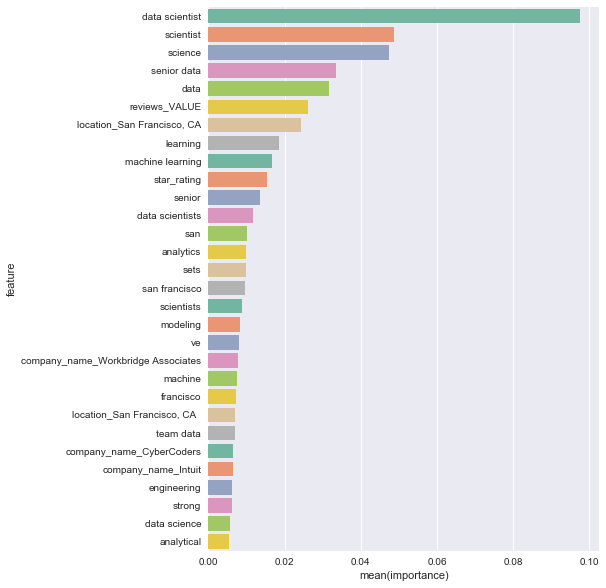

In [185]:
feature_import_ds = pd.DataFrame({
    'feature': X_ds.columns,
    'importance': rfc_ds.feature_importances_
}).sort_values('importance', ascending=False)

fig = plt.figure(figsize=(7,10))
sns.barplot(y = feature_import_ds.head(30)['feature'], x = feature_import_ds.head(30)['importance'], orient='h',
           palette="Set2")

## Interpretation of Results

Unsurprisingly, words like 'data scientist" and 'science' come up as having the most importance in differentiating these groups.  Words like machine learning and learning also come up, probably connected to data science roles as opposed to other data roles.  It's interesting that the differentiating words are more clearly associated with data science than other data roles, which indicates that data science roles have specific skills like machine learning that differentiate them from other data roles, but not so much the other way around.


Let's look a little deeper into some of the less obvious ones, like reviews and star rating.

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


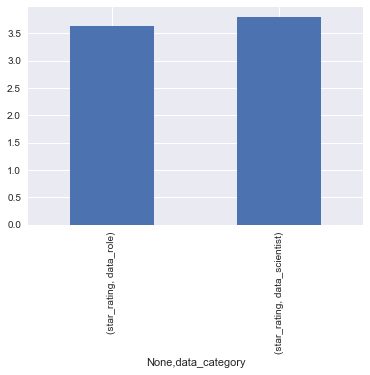

In [186]:
X_ds['data_category'] = y_ds

X_ds[['data_category', 'star_rating']].groupby('data_category').mean().unstack().plot(kind="bar")


In [ ]:
# Looks like data science jobs are generally at companies that have a higher average star rating.

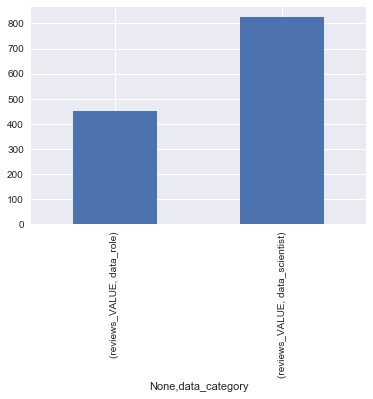

In [188]:
X_ds[['data_category', 'reviews_VALUE']].groupby('data_category').mean().unstack().plot(kind="bar")

In [ ]:
# Companies with data science jobs generally have almost twice as many reviews! Pretty stark contrast.

## B. Distinguishing junior vs. senior positions

In [277]:
# first let's create categories for junior and senior level positions.

junior_senior = []
for i, title in enumerate(df.job_title):
    title = title.lower()
    if "entry level" in df.summary[i] or "junior" in title:
        junior_senior.append('junior')
    elif "manager" in title or 'senior' in title:
        junior_senior.append('senior')
    else:
        junior_senior.append('unclear_seniority')


In [278]:
df['seniority'] = junior_senior

In [198]:
df.seniority.value_counts()

unclear_seniority    18111
senior                2035
junior                 308
Name: seniority, dtype: int64

In [279]:
df_words['seniority'] = junior_senior

### Prepping Data for Modeling:

In [281]:
X_js = df_words.copy()

In [283]:
for c in X_js.columns:
    if "job_title" in c:
        del(X_js[c])

In [282]:
X_js = X_js[X_js['seniority'] != "unclear_seniority"]

In [284]:
y_js = X_js['seniority']
del(X_js['seniority'])

### Modeling

In [288]:
# First let's look at our baseline.

y_js.value_counts()

senior    2035
junior     308
Name: seniority, dtype: int64

In [290]:
baseline = 2035./(308+2035)
baseline

0.8685446009389671

In [285]:
# Need to get rid of the salary range column.

del(X_js['salary_range'])

In [214]:
# let's start out by looking at random forest, which has been performing so well.

param_grid_js = {
    "max_depth": [10,15,20],
    "max_features": [100,150,200],
    "n_estimators": [5,10,20,40]
}

rfc_js = RandomForestClassifier()

gscv_rfc_js = GridSearchCV(rfc_js, param_grid_ds, cv=3, verbose=1)

gscv_rfc_js.fit(np.array(X_js), y_js)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [100, 150, 200], 'n_estimators': [5, 10, 20, 40], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [216]:
gscv_rfc_js.best_params_

{'max_depth': 20, 'max_features': 200, 'n_estimators': 40}

In [ ]:
# We could perhaps tune these better.

In [217]:
# Great score!

gscv_rfc_js.best_score_

0.98164746052069995

In [221]:
param_grid_js = {
    "max_depth": [20,30,40],
    "max_features": [200,300,400],
    "n_estimators": [40,50,60]
}

rfc_js = RandomForestClassifier()

gscv_rfc_js = GridSearchCV(rfc_js, param_grid_ds, cv=3, verbose=1)

gscv_rfc_js.fit(np.array(X_js), y_js)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [100, 150, 200], 'n_estimators': [5, 10, 20, 40], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [222]:
# interesting that some of the best parameters changed, indicates that it may not be all that important.

gscv_rfc_js.best_params_

{'max_depth': 20, 'max_features': 200, 'n_estimators': 20}

In [ ]:
# The score just sin't changing very much, doesn't really seem to matter what our parameters are.

In [223]:
gscv_rfc_js.best_score_

0.98250106700810924

In [ ]:
# Let's try looking at logistic regression on this next since it worked so well before.

In [301]:
# because our baseline is so high, we're going to want to weight our target variable.

log_reg = LogisticRegression()

params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.05,1,20),
    'class_weight': [{'junior': 0.8, 'senior': 0.2}, {'junior': 0.9, 'senior': 0.1},
                     {'junior': 0.7, 'senior': 0.3}, {'junior': 0.6, 'senior': 0.4},
                     None]
}

log_reg_gs = GridSearchCV(log_reg, params, cv=3, verbose=1)

In [302]:
log_reg_gs.fit(np.array(X_js), y_js)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ]), 'class_weight': [{'senior': 0.2, 'junior': 0.8}, {'senior': 0.1, 'junior': 0.9}, {'senior': 0.3, 'junior': 0.7}, {'senior': 0.4, 'junior': 0.6}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [305]:
# interesting that no class weight actually works out best.

log_reg_gs.best_params_

{'C': 0.59999999999999998, 'class_weight': None, 'penalty': 'l1'}

In [303]:
# not quite as good as our random forest, I'll just stick with that.

log_reg_gs.best_score_

0.98036705078958597

In [224]:
# making a new random forest model with the best parameters from the gridsearch.

rfc_js = RandomForestClassifier(max_depth=20, max_features=200, n_estimators=20)

rfc_js.fit(np.array(X_js), y_js)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=200, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

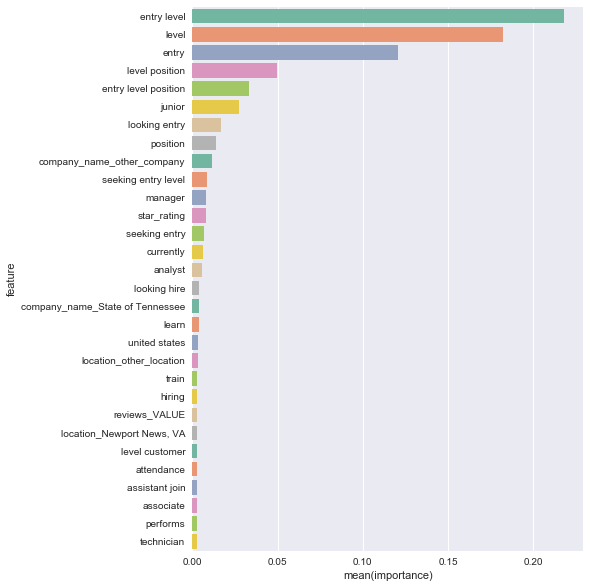

In [225]:
# plotting feature importances

feature_import_js = pd.DataFrame({
    'feature': X_js.columns,
    'importance': rfc_js.feature_importances_
}).sort_values('importance', ascending=False)

fig = plt.figure(figsize=(7,10))
sns.barplot(y = feature_import_js.head(30)['feature'], x = feature_import_js.head(30)['importance'], orient='h',
           palette="Set2")

In [226]:
# Pretty inuitive results here, words in the summary like "entry level", "entry" and "entry level position" are 
# all high up in terms of differentiating.  This could also be based on the way that I defined junior level vs.
# senior level positions, which used permuations of those words.  But, it's hard to imagine a better way to do it.


# we could go back to indeed, and scrape based on their search parameters for "entry" and "senior" level positions,
# and then go through the same process for modeling the data.

## C. How do job requirements vary by industry?

First we need to classify industry for a bunch of jobs.  Let's look at the companies that have the most jobs, and classify those.  We should be able to get a big enough sample of classified industries doing this.

In [296]:
df.company_name.value_counts()[25:]

ReqRoute,Inc                               45
Panda Express                              43
Nationwide Doctors Inc                     42
Pro-Touch Nurses Inc.                      40
Macy's                                     40
Open Systems Technologies, Inc.            38
Open Door Unlimited, Inc.                  38
Alliant Insurance Services                 37
Victoria's Secret                          37
American Management Services, Inc.         36
Electronic Search, Inc.                    33
Walmart                                    33
TARGET                                     33
EMSI, Inc.                                 31
Nike                                       30
Etech Hi Inc.                              28
Uber                                       28
Anthropologie                              27
Anthem, Inc.                               27
Comtech Global Inc                         27
Aramark                                    27
Global Payments                   

In [307]:
# skipping companies that are recruiters.

industry_categories = {
    "Lowe's Inc.": "retail",
    "Kindred At Home": "healthcare",
    "Kwik Trip Inc": "retail",
    "Securitas Security Services USA, Inc": "security",
    "SouthernCare, Inc.": "healthcare",
    "J.Crew Group, Inc.": "retail",
    "Maxim Healthcare Services": "healthcare",
    "Bio-Reference Laboratories, Inc.": "pharmaceutical",
    "Pfizer Inc.": "pharmaceutical",
    "Safeway Inc": "retail",
    "Safeway": "retail",
    "Sodexo Inc.": "healthcare",
    "Apex Systems Inc": "IT",
    "7-Eleven": "retail",
    "Regeneron": "pharmaceutical",
    "Southern Star, Inc.": "retail",
    "Marriott International, Inc": "hospitality",
    "Pathfinders, Inc.": "IT",
    "Planet Fitness Franchises": "fitness",
    "Toys R Us": "retial",
    "Pfizer, Inc.": "pharmaceutical",
    "Nordstrom": "retail",
    "Whole Foods Market": "retail",
    "Panda Express": "dining",
    "Nationwide Doctors Inc": "healthcare",
    "Pro-Touch Nurses Inc.": "healthcare",
    "Macy's": "retail",
    "Open Systems Technologies, Inc.": "IT",
    "Alliant Insurance Services": "insurance",
    "Victoria's Secret": "retail",
    "American Management Services, Inc.": "consulting",
    "Walmart": "retial",
    "TARGET": "retial",
    "EMSI, Inc.": "healthcare",
    "Nike": "clothing",
    "Uber": "technology",
    "Anthropologie": "retail",
    "Anthem, Inc.": "insurance",
    "Comtech Global Inc": "technology",
    "Aramark": "food_services",
    "CRH-Oldcastle": "wholesale"
}

In [309]:
# Let's see if this is enough to do some modeling.

# we'll loop through all the company names, see if they show up in the dictionary we made,
# and if they do, append the value corresponding to the industry in the dictionary to a list.

industry = []

for company in df.company_name:
    if company in industry_categories.keys():
        industry.append(industry_categories[company])
    else:
        industry.append("unknown")
        

In [310]:
df['industry'] = industry

In [311]:
# I think we've got enough to go on here, we can at least see if there are some differences between the 3 biggest
# categories, retail, healthcare, and pharma.

df.industry.value_counts()

unknown           17597
retail             1249
healthcare          536
pharmaceutical      291
IT                  168
retial              116
security            107
insurance            64
hospitality          58
technology           55
fitness              51
dining               43
consulting           36
clothing             30
food_services        27
wholesale            26
Name: industry, dtype: int64

In [318]:
# Let's make our dataframe of count vectorized words.  We're going to want to get rid of all the value columns,
# and the job title columns.

X_ind = df_words.copy()

In [319]:
for c in X_ind.columns:
    if 'job_title' in c:
        del(X_ind[c])

In [320]:
for c in X_ind.columns:
    if "_VALUE" in c:
        del(X_ind[c])

In [321]:
# let's add the industry classiciations to our data now, and then limit the data to just cases
# where the industry is not "unknown"

X_ind['industry'] = industry
X_ind = X_ind[X_ind['industry'] != "unknown"]

In [324]:
# get rid of salary range from our X

del(X_ind['salary_range'])

In [326]:
# we also need to get rid of all the location and company name columns, and the seniority column

del(X_ind['seniority'])

for c in X_ind.columns:
    if "company_name_" in c:
        del(X_ind[c])

for c in X_ind.columns:
    if "location_" in c:
        del(X_ind[c])      



In [327]:
# and star rating.  We just care about the words from the summaries.

del(X_ind['star_rating'])

In [329]:
tf_df    =  pd.DataFrame(X_ind.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False)[2:15]

# looks like words associated with "kwik trip" are coming up a lot, which means that that company is way 
# over represented in the data.  The model will probably not generalize well because of that.

# at this point I'd probably want to go back and gather more data for this problem, but I'm going to plow ahead.

,freq
position,659
kwik,518
trip,501
kwik trip,501
store,482
home,466
services,378
job,347
work,321
care,314


In [330]:
# Let's look just at healthcare.

tf_df    =  pd.DataFrame(X_ind[X_ind['industry']=="healthcare"].sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False)[2:15]

# A lot of words pretty clearly associated with healthcare here.  Interesting that "home" shows up on the top,
# may be a lot of in home care.

,freq
home,460
care,302
kindred,300
healthcare,262
hospice,227
services,200
medical,179
health,169
leading,167
home health,156


In [331]:
# now let's look at just retail

tf_df    =  pd.DataFrame(X_ind[X_ind['industry']=="retail"].sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False)[2:15]

# this is where kwik trip seems to be dominating, all there descriptions must be really similar.  also seems like
# there's a typo in "descriptionresponsible" which will probably screw our model up a bit.  I may just end up
# dropping kwik trip job descriptions from the dataset.

,freq
position,576
kwik,518
trip,501
kwik trip,501
store,426
descriptionresponsible,256
position descriptionresponsible,254
includes,228
customers,216
merchandise,199


### Modeling

In [332]:
# now let's get our y set up and remove 'industry' from X

y_ind = X_ind['industry']
del(X_ind['industry'])

In [334]:
# first let's calculate our baseline

y_ind.value_counts()

retail            1249
healthcare         536
pharmaceutical     291
IT                 168
retial             116
security           107
insurance           64
hospitality         58
technology          55
fitness             51
dining              43
consulting          36
clothing            30
food_services       27
wholesale           26
Name: industry, dtype: int64

In [336]:
baseline = float(y_ind.value_counts()[0])/sum(y_ind.value_counts().values)

In [337]:
baseline

0.4371718585929297

In [333]:
# Let's start by using a random forest model.

rfc_ind = RandomForestClassifier()

params_ind = {
    "max_depth": [20,30,40],
    "n_estimators": [10,20,30],
    "max_features": [100,150,200,250]
}

gscv_ind = GridSearchCV(rfc_ind, params_ind, cv=3, verbose=1)

In [339]:
gscv_ind.fit(np.array(X_ind), y_ind)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': [100, 150, 200, 250], 'max_depth': [20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [340]:
gscv_ind.best_score_

0.72593629681484073

In [341]:
gscv_ind.best_params_

{'max_depth': 40, 'max_features': 150, 'n_estimators': 30}

In [342]:
# going to try this again with higher depth

params_ind = {
    "max_depth": [40,50,60],
    "n_estimators": [30],
    "max_features": [100,150,200]
}

gscv_ind = GridSearchCV(rfc_ind, params_ind, cv=3, verbose=1)

In [343]:
gscv_ind.fit(np.array(X_ind), y_ind)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   56.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [30], 'max_features': [100, 150, 200], 'max_depth': [40, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [344]:
gscv_ind.best_score_

0.7248862443122156

In [345]:
gscv_ind.best_params_

{'max_depth': 50, 'max_features': 100, 'n_estimators': 30}

In [346]:
# Our model is staying pretty similar even while tweeking these values.
# Let's try logistic regression

log_reg_ind = LogisticRegression()

params_ind_lr = {
    "C": np.linspace(0.05,1,20),
    "penalty": ['l1', 'l2']
}

gscv_ind_lr = GridSearchCV(log_reg_ind, params_ind_lr, cv=3, verbose=1)

In [347]:
gscv_ind_lr.fit(np.array(X_ind), y_ind)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [348]:
# looks like logistic regression is actually performing a bit better on this problem!

gscv_ind_lr.best_score_

0.73538676933846692

In [349]:
gscv_ind_lr.best_params_

{'C': 0.050000000000000003, 'penalty': 'l2'}

In [350]:
# Let's try using some smaller C values, since the best performing was our lowest C from the gridsearch.

params_ind_lr = {
    "C": np.linspace(0.005,0.1,30),
    "penalty": ['l1', 'l2']
}

gscv_ind_lr = GridSearchCV(log_reg_ind, params_ind_lr, cv=3, verbose=1)

In [351]:
gscv_ind_lr.fit(np.array(X_ind), y_ind)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.005  ,  0.00828,  0.01155,  0.01483,  0.0181 ,  0.02138,
        0.02466,  0.02793,  0.03121,  0.03448,  0.03776,  0.04103,
        0.04431,  0.04759,  0.05086,  0.05414,  0.05741,  0.06069,
        0.06397,  0.06724,  0.07052,  0.07379,  0.07707,  0.08034,
        0.08362,  0.0869 ,  0.09017,  0.09345,  0.09672,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [352]:
# managed to improve the model a tiny bit.

print gscv_ind_lr.best_score_, gscv_ind_lr.best_params_

0.73608680434 {'penalty': 'l2', 'C': 0.047586206896551721}


In [354]:
# let's fit a logistic regression with the best parameters.

log_reg_ind = LogisticRegression(C=gscv_ind_lr.best_params_['C'], penalty=gscv_ind_lr.best_params_['penalty'])
log_reg_ind.fit(np.array(X_ind), y_ind)

LogisticRegression(C=0.047586206896551721, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [359]:
# Let's make a coefficient dataframe we can look at

coef_matrix = pd.DataFrame(log_reg_ind.coef_.T, columns=log_reg_ind.classes_, index=X_ind.columns)

In [360]:
coef_matrix

,IT,clothing,consulting,dining,fitness,food_services,healthcare,hospitality,insurance,pharmaceutical,retail,retial,security,technology,wholesale
index,-0.000065,-0.000367,-0.000503,-0.000180,-0.000533,-4.432659e-04,0.000012,-0.000265,-0.000251,-0.000067,-0.000151,-0.000152,-0.000155,-0.000172,-0.000264
00,-0.027253,-0.002245,-0.000672,-0.006986,-0.000765,-3.811961e-04,-0.030272,-0.006028,-0.004533,0.049913,-0.023726,-0.008175,0.041562,0.047554,-0.005262
00 00,-0.004192,-0.000243,-0.000075,-0.000991,-0.000084,-3.691264e-05,-0.005060,-0.000797,-0.000608,0.008478,-0.003251,-0.001154,-0.001249,0.026260,-0.000681
00 hour,-0.006003,-0.000601,-0.000188,-0.001600,-0.000221,-1.163059e-04,-0.005114,-0.001426,-0.001095,-0.006547,-0.005155,-0.001764,0.029562,-0.001649,-0.001400
00 pm,-0.010295,-0.000854,-0.000278,-0.002984,-0.000309,-1.460205e-04,-0.010752,-0.002634,-0.001961,0.051210,-0.008453,-0.003481,-0.003645,-0.003000,-0.002273
000,0.045002,-0.009553,-0.006635,-0.010230,-0.006972,1.124515e-01,-0.027243,-0.015888,-0.010341,-0.020040,-0.039167,-0.012176,-0.011667,-0.011268,-0.010875
00pm,-0.017396,-0.004670,-0.003268,-0.007403,-0.003424,-3.798299e-03,-0.019551,-0.007837,-0.006658,0.038798,-0.013272,-0.008886,0.006658,-0.008342,-0.007086
10,-0.007974,-0.023926,-0.014756,-0.003923,-0.015227,-1.763158e-02,-0.064911,-0.031131,-0.024348,-0.033881,0.073003,-0.033276,0.000882,0.024057,-0.025891
10 years,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,-0.055359,-0.061080,-0.049710,-0.062292,-0.055629,-7.876479e-02,-0.081065,-0.071324,-0.075582,-0.085320,0.204272,-0.102783,-0.089546,-0.086240,-0.067711


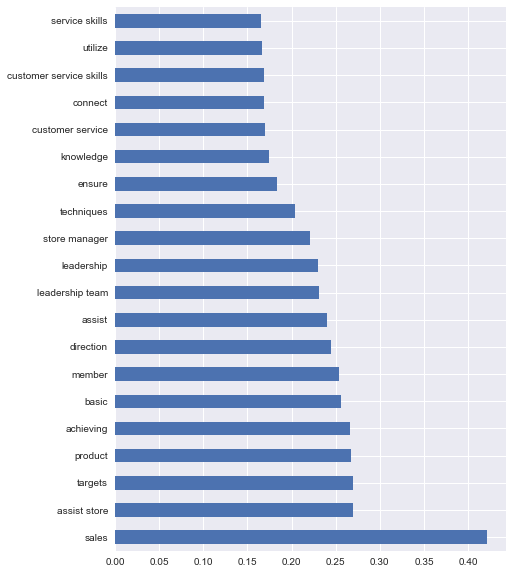

In [377]:
# Let's look at the top coefficients for a few categories, and see if they're different.

# We could also look at the the intersection of the topwords to see how much overlap there is between industries.

# interest that "sales" is so high up on retail, along with other intuitive words like 'product' and customer
# service related words.

# we could even do a jacard similarity between industries.

coef_matrix['clothing'].sort_values(ascending=False).head(20).plot(kind='barh', figsize=(7,10))

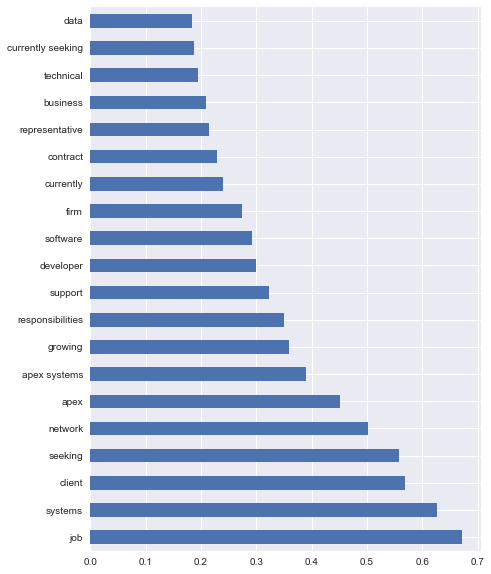

In [376]:
coef_matrix['IT'].sort_values(ascending=False).head(20).plot(kind='barh', figsize=(7,10))

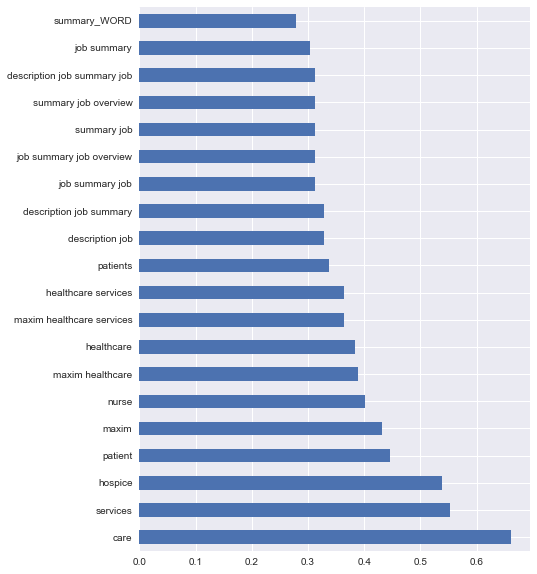

In [375]:
coef_matrix['healthcare'].sort_values(ascending=False).head(20).plot(kind='barh', figsize=(7,10))

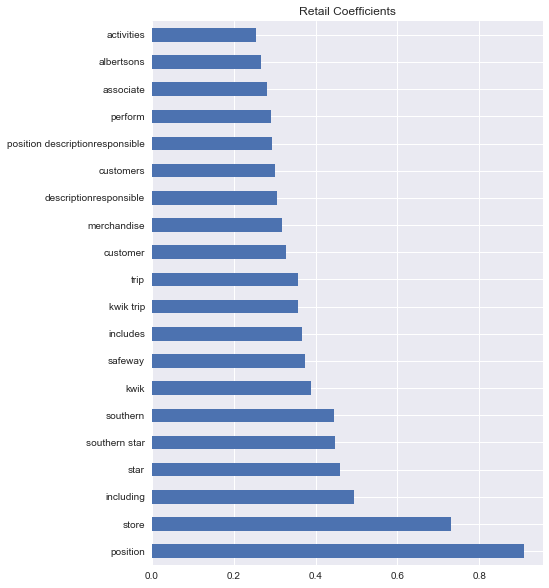

In [378]:
# The model appears to have learned to specific keywords associated with companies more so than industries.

# We're seeing names of companies come up here.

coef_matrix['retail'].sort_values(ascending=False).head(20).plot(kind='barh', figsize=(7,10), title="Retail Coefficients")

In [410]:
def jaccard(list1, list2):
    """ This function takes in two lists and returns the jaccard similarity between them."""
    union = set(list1).intersection(set(list2))
    distinct = set(list1).union(set(list2))
    jaccard = float(len(union))/len(distinct)
    return jaccard


# first we'll go through all the industries, and find the coefficients for the words/phrases that are most strongly
# predictive of that industry.
industry_list = []
for industry in coef_matrix.columns:
    industry_top_words = coef_matrix[industry].sort_values(ascending=False).head(50).index.tolist()
    industry_dict = {'industry': industry,
                    'top_words': industry_top_words}
    industry_list.append(industry_dict)

# this is a dataframe with two columns, one for each industry, and another with a list of the top words in that
# industry.
jaccard_df = pd.DataFrame(industry_list)


# now we're going to loop through all the industries, calculcate the jaccard score for that industry's words with
# every other industry, and put those into a new dataframe.
jaccards = []
for industry in jaccard_df.industry:
    top_words = jaccard_df.loc[jaccard_df['industry'] == industry, 'top_words'].values[0]
    jaccard_scores = {}
    for i, words in enumerate(jaccard_df.top_words):
        jaccard_score = jaccard(words, top_words)
        jaccard_scores[coef_matrix.columns[i]] = jaccard_score
    jaccards.append(jaccard_scores)
    
industry_jacard_scores= pd.DataFrame(jaccards, index=coef_matrix.columns)

In [411]:
def heat_map(df):
    
    # set figure size
    fig, ax = plt.subplots(figsize = (11, 7))
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(df, mask=mask, annot = True)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    
    plt.show()

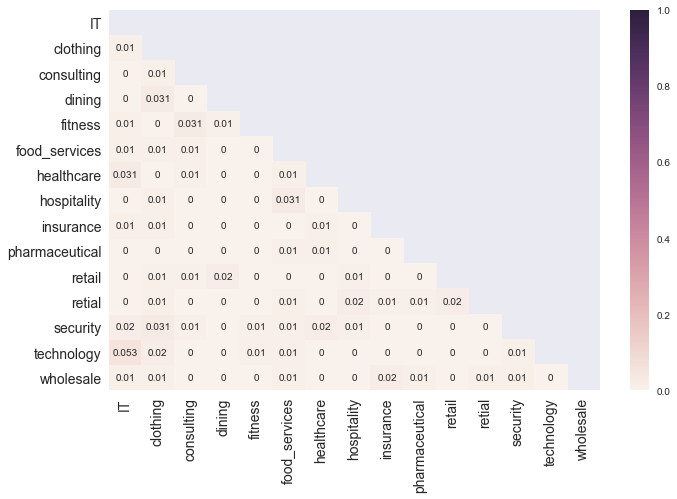

In [412]:
heat_map(industry_jacard_scores)

# Looks like there really isn't too much similarity between industries with regard to what words define those
# roles.

One drawback of looking at if there are differences between what skills are required for jobs using a model like this is that the model is going to intentionally try to find the differences as opposed to similarities between words.  Rather than doing any modelling at all, we may just want to look at the jacard similaries between the top words associated from the count vectorization step for each industry, and look at the jaccard similarities between those.

In [414]:
## let's look at jaccard similarities of just the top 50 most common words for each industry.

del(X_ind['industry'])

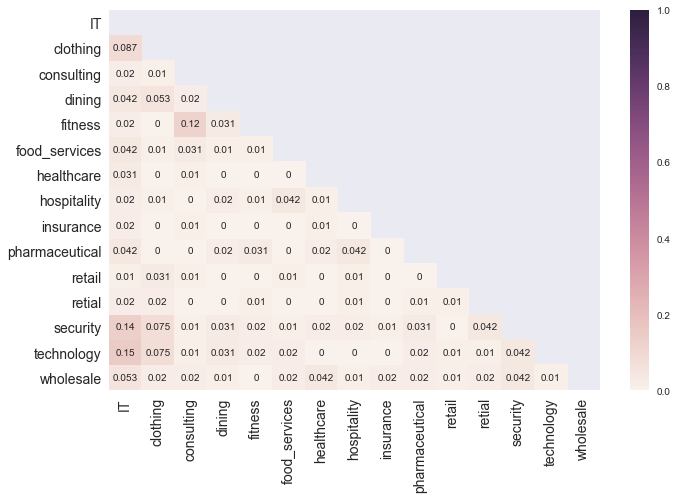

In [433]:
# first we'll go through all the industries, and find the coefficients for the words/phrases that are most strongly
# predictive of that industry.

def jaccard_sims_ind(top_x_words=50):
    industry_list = []
    for industry in coef_matrix.columns:
        x_df = pd.DataFrame(X_ind[y_ind == industry], columns=columns)
        tf_df = pd.DataFrame(x_df.sum(), columns=["freq"])

        # looking at the top 100 most frequent words and phrases for each industry
        industry_top_words = tf_df.sort_values("freq", ascending=False).head(top_x_words).index.tolist()
        industry_dict = {'industry': industry,
                        'top_words': industry_top_words}
        industry_list.append(industry_dict)

    # this is a dataframe with two columns, one for each industry, and another with a list of the top words in that
    # industry.
    jaccard_df = pd.DataFrame(industry_list)


    # now we're going to loop through all the industries, calculcate the jaccard score for that industry's words with
    # every other industry, and put those into a new dataframe.
    jaccards = []
    for industry in jaccard_df.industry:
        top_words = jaccard_df.loc[jaccard_df['industry'] == industry, 'top_words'].values[0]
        jaccard_scores = {}
        for i, words in enumerate(jaccard_df.top_words):
            jaccard_score = jaccard(words, top_words)
            jaccard_scores[coef_matrix.columns[i]] = jaccard_score
        jaccards.append(jaccard_scores)

    industry_jaccard_scores = pd.DataFrame(jaccards, index=coef_matrix.columns)

    heat_map(industry_jaccard_scores)
    return

jaccard_sims_ind()

In [434]:
# even looking at things this way, there really doesn't appear to be TOO much overlap with regard to key words 
# in job descriptions.  We see the most similarity between technology and IT.   There are some odd connections,
# like with consulting and fitness.  It may be interesting to dive deeper into the industries where there are overlaps
# and explort that a little deeper.

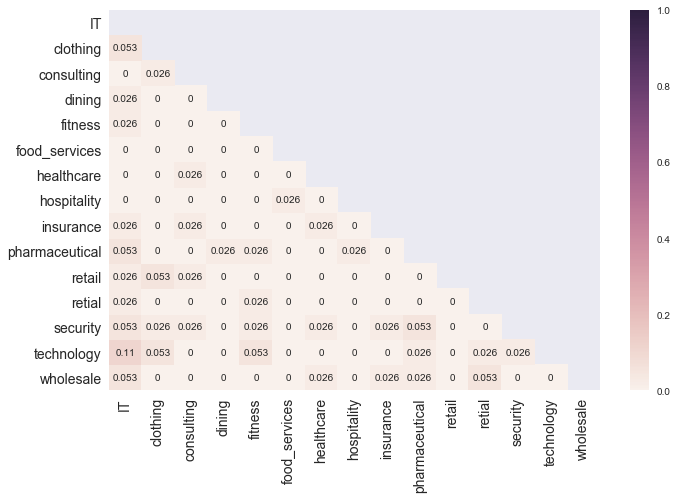

In [437]:
# Let's look at just the top 20 words.

jaccard_sims_ind(20)

### Results

Without looking deeper, it seems pretty clear that there are some skills that differentiate between industries, but also some words that show up in multiple industries.

For instances, words associated with sales seem to come up a lot in the context of retail jobs, and not in others, but we see things associated with customer service in both healthcare and retail.  

In general, there do seem to be industry specific keywords that differentiate them from one another.

Moving forward, it would be good to go back to the industry definition part of this process, and expand the number
of companies involved.  By picking to classify industries based on large companies, the model seems to have learned more of the specific keywords associated with companies as opposed to whole industries.